In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
from astropy import units as u
from scipy.optimize import minimize
from scipy.stats import linregress
print astropy.__version__
import math
import emcee
import corner

import matplotlib 
%matplotlib notebook

from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

import winsound

import time

winsound.Beep(440,1500)

2.0.2


In [2]:
class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}

class arcoiris_merged_spectrum(object):
    def __init__(self, name, data, date):
        self.objectname = name
        self.obsdate = date
        
        tempwav = []
        tempflux = []
        temperr = []
        #tempsnr = []
        
        for line in data:
            conts = line.split()
            tempwav.append(float(conts[0]))
            tempflux.append(float(conts[1]))
            temperr.append(float(conts[2]))
            
        self.wav = np.array(tempwav)
        self.flux = np.array(tempflux)
        self.err = np.array(temperr)
        self.snr = self.flux/self.err
        
        self.flux_watts = self.flux*10.
        self.err_watts = self.err*10.
        
    def __str__(self):
        s = 'Wav Flux Err \n'
        for i in range(self.wav.size):
            s = s + str(self.wav[i]) + ' ' + str(self.flux[i]) + ' ' + str(self.err[i]) + '\n'
            
        return s
    
    def get_snr_cut_spectrum(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
    
    def get_snr_cut_spectrum_watts(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
        
        
class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return
    
class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig

class continuum_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        wavelength_list = []
        flux_density_list = []
        #full_error_list = []        
        #short_wavelength_list = []
        #short_flux_density_list = []
        #short_error_list = []
        #long_wavelength_list = []
        #long_flux_density_list = []
        #long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            #error = float(comps[2])
        
            #if (wav < -900.) or (flux < -900.) or (error < -900.):
            #    continue

            wavelength_list.append(float(comps[0]))
            flux_density_list.append(float(comps[1]))
            #full_error_list.append(float(comps[2]))
            
            #if wav < 2.75:
            #    short_wavelength_list.append(float(comps[0]))
            #    short_flux_density_list.append(float(comps[1]))
            #    short_error_list.append(float(comps[2]))
            #else:
            #    long_wavelength_list.append(float(comps[0]))
            #    long_flux_density_list.append(float(comps[1]))
            #    long_error_list.append(float(comps[2]))                
        
        self.wavelength = np.array(wavelength_list)
        self.flux_density = np.array(flux_density_list)
        #self.full_error = np.array(full_error_list)
        
        #self.short_wavelength = np.array(short_wavelength_list)
        #self.short_flux_density = np.array(short_flux_density_list)
        #self.short_error = np.array(short_error_list)
        #self.long_wavelength = np.array(long_wavelength_list)
        #self.long_flux_density = np.array(long_flux_density_list)
        #self.long_error = np.array(long_error_list)
    
        return

In [3]:
def import_arcoiris_from_text(filename, name, date):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_merged_spectrum(name, data, date)
    
    return spectrum

def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum

def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum

def import_continuum_spectrum_from_file(filename):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = continuum_spectrum(data)
    return spectrum

In [4]:
awi0005x3s_20171104_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_remerged.txt','AWI0005x3s','2017-11-04')
awi0005x3s_20180301_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180301_remerged.txt','AWI0005x3s','2018-03-01')
awi0005x3s_20180302_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180302_remerged.txt','AWI0005x3s','2018-03-02')

awi0005x3s_20171104_2massweighted_merged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_2massweighted_merged.txt','AWI0005x3s','2017-11-04')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

First row found: 47


In [6]:
awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts, awi0005x3s_20171104_highsnr_err = awi0005x3s_20171104_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts, awi0005x3s_20180301_highsnr_err = awi0005x3s_20180301_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts, awi0005x3s_20180302_highsnr_err = awi0005x3s_20180302_remerged.get_snr_cut_spectrum_watts(20.)

awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts, awi0005x3s_20171104_2mass_highsnr_err = awi0005x3s_20171104_2massweighted_merged.get_snr_cut_spectrum_watts(20.)


<IPython.core.display.Javascript object>


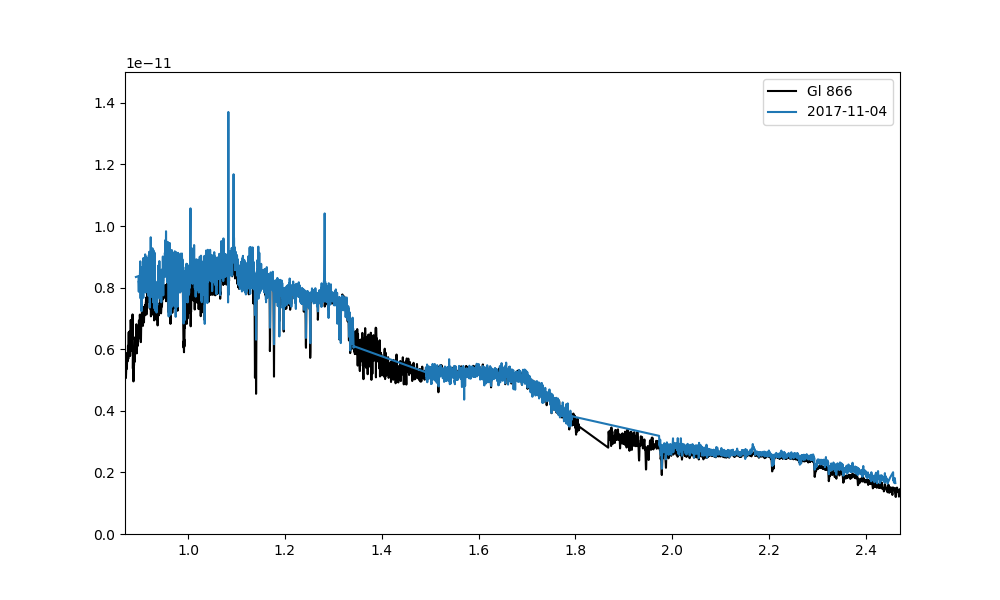

In [7]:
plt.figure(figsize=(10.,6.))

plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts/0.00245,label='2017-11-04')
#plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts*380.,label='2018-03-01')
#plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts*410.,label='2018-03-02')

wav_20171104_angstroms = awi0005x3s_20171104_highsnr_wav*10000.
wav_20180301_angstroms = awi0005x3s_20180301_highsnr_wav*10000.
wav_20180302_angstroms = awi0005x3s_20180302_highsnr_wav*10000.

wav_20171104_2mass_angstroms = awi0005x3s_20171104_2mass_highsnr_wav*10000.

#bb_20171104 = blackbody_lambda(wav_20171104_angstroms * u.AA, 1071.) #* np.pi * u.sr * u.cm * u.cm * u.s / u.erg * wav_20171104_angstroms * u.AA / awi0005x3s_20171104_remerged.wav

#print max(bb_20171104)

#print max(bb_20171104*0.11)

#plt.plot(awi0005x3s_20171104_highsnr_wav, bb_20171104*0.11)

plt.xlim([0.87,2.47])
plt.ylim([0.,1.5e-11])

plt.legend(loc='upper right')

plt.show()

In [8]:
#awi0005x3s_20171104_remerged_wav_angstroms = awi0005x3s_20171104_remerged.wav * 10000.

#stellar radius in meters
rstar = 0.30 * 695700000.

#distance from trig. parallax, in meters
dstar = (1000./9.8599) * 3.08567758149137e16

rdstar = (rstar**2)/(dstar**2)

print rdstar

Tdisk = 1071.
Tstar = 3050.

Tratio = (Tdisk/Tstar)**4

print Tratio

max_xdisk = 0.11 / Tratio * rdstar

print max_xdisk

bestfit_xdisk = 0.054 / Tratio * rdstar

print bestfit_xdisk

test_xdisk = 0.10 /Tratio * rdstar

template_wav_angstroms = template_spectrum.short_wavelength * 10000.

awi0005x3s_20171104_2mass_merged_blackbody = blackbody_lambda(wav_20171104_2mass_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20171104_2mass_angstroms_trunclong = np.array([x for x in wav_20171104_2mass_angstroms if x > (2.285e4)])
awi0005x3s_20171104_2mass_merged_blackbody_trunclong = blackbody_lambda(wav_20171104_2mass_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict = {wav_20171104_2mass_angstroms_trunclong[i]: awi0005x3s_20171104_2mass_merged_blackbody_trunclong[i] for i in range(awi0005x3s_20171104_2mass_merged_blackbody_trunclong.size)}

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting = np.zeros(wav_20171104_2mass_angstroms.size)
for i in range(wav_20171104_2mass_angstroms.size):
    if wav_20171104_2mass_angstroms[i] > 2.285e4:
        awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting[i] = awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict[wav_20171104_2mass_angstroms[i]]

template_wav_angstroms_trunclong = np.array([x for x in template_wav_angstroms if x > (2.285e4)])
template_blackbody_trunclong = blackbody_lambda(template_wav_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

template_blackbody_trunclong_dict = {template_wav_angstroms_trunclong[i]: template_blackbody_trunclong[i] for i in range(template_blackbody_trunclong.size)}

template_blackbody_trunclong_plotting = np.zeros(template_wav_angstroms.size)
for i in range(template_wav_angstroms.size):
    if template_wav_angstroms[i] > 2.285e4:
        template_blackbody_trunclong_plotting[i] = template_blackbody_trunclong_dict[template_wav_angstroms[i]]


print max(awi0005x3s_20171104_2mass_merged_blackbody)

4.44764838653e-21
0.015204023281
3.21784118241e-20
1.57966748955e-20
5.18550045273e-16


In [9]:
test_xdisk_20180301 = 0.11 / Tratio * rdstar

awi0005x3s_20180301_blackbody = blackbody_lambda(wav_20180301_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180301_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180301_angstroms_trunclong = np.array([x for x in wav_20180301_angstroms if x > (2.285e4)])
awi0005x3s_20180301_blackbody_trunclong = blackbody_lambda(wav_20180301_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180301_blackbody_trunclong_dict = {wav_20180301_angstroms_trunclong[i]: awi0005x3s_20180301_blackbody_trunclong[i] for i in range(awi0005x3s_20180301_blackbody_trunclong.size)}

awi0005x3s_20180301_blackbody_trunclong_plotting = np.zeros(wav_20180301_angstroms.size)
for i in range(wav_20180301_angstroms.size):
    if wav_20180301_angstroms[i] > 2.285e4:
        awi0005x3s_20180301_blackbody_trunclong_plotting[i] = awi0005x3s_20180301_blackbody_trunclong_dict[wav_20180301_angstroms[i]]

In [10]:
test_xdisk_20180302 = 0.09 / Tratio * rdstar

awi0005x3s_20180302_blackbody = blackbody_lambda(wav_20180302_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180302_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180302_angstroms_trunclong = np.array([x for x in wav_20180302_angstroms if x > (2.285e4)])
awi0005x3s_20180302_blackbody_trunclong = blackbody_lambda(wav_20180302_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180302_blackbody_trunclong_dict = {wav_20180302_angstroms_trunclong[i]: awi0005x3s_20180302_blackbody_trunclong[i] for i in range(awi0005x3s_20180302_blackbody_trunclong.size)}

awi0005x3s_20180302_blackbody_trunclong_plotting = np.zeros(wav_20180302_angstroms.size)
for i in range(wav_20180302_angstroms.size):
    if wav_20180302_angstroms[i] > 2.285e4:
        awi0005x3s_20180302_blackbody_trunclong_plotting[i] = awi0005x3s_20180302_blackbody_trunclong_dict[wav_20180302_angstroms[i]]

<IPython.core.display.Javascript object>


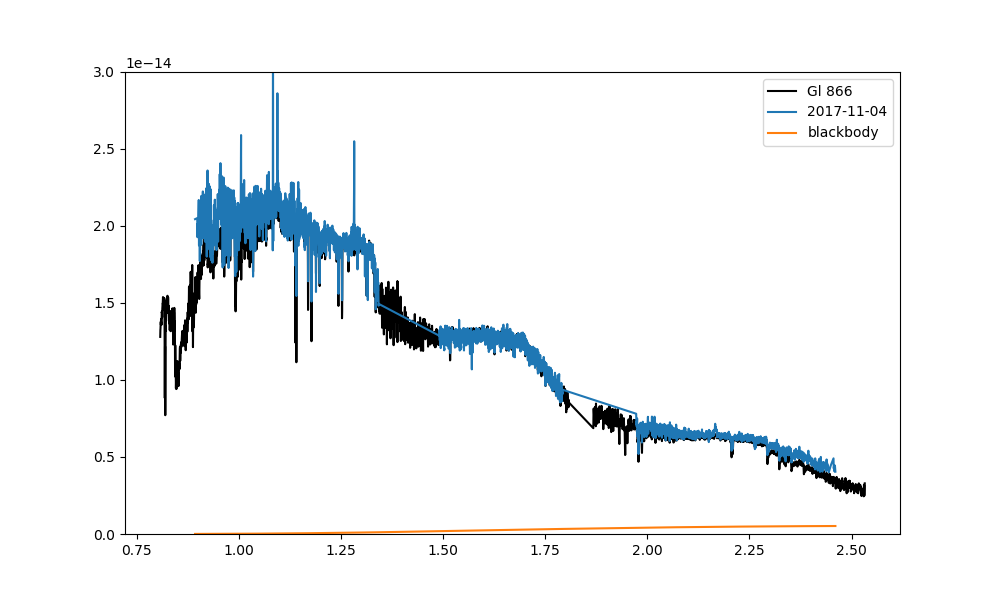

<IPython.core.display.Javascript object>


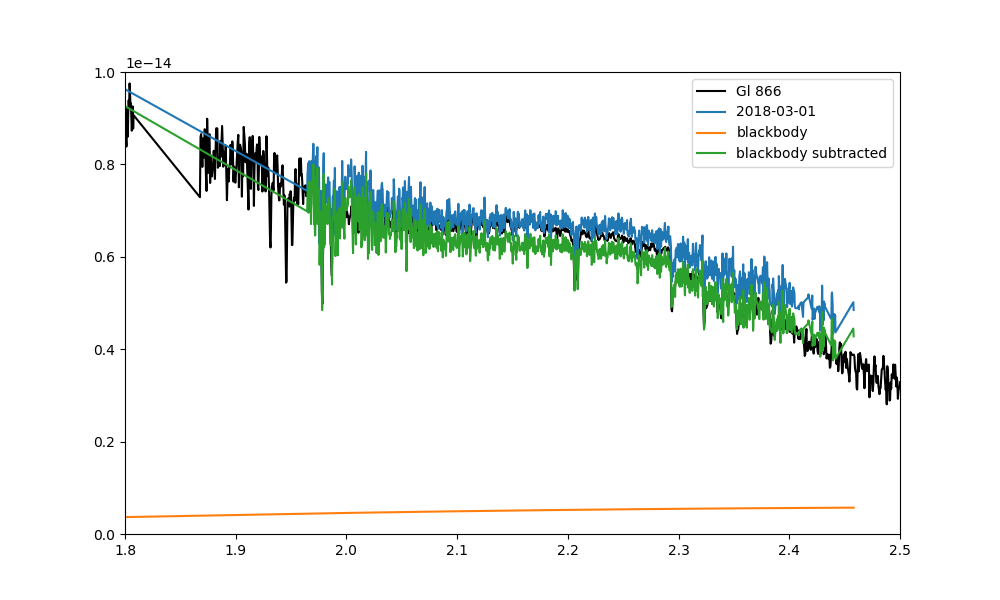

<IPython.core.display.Javascript object>


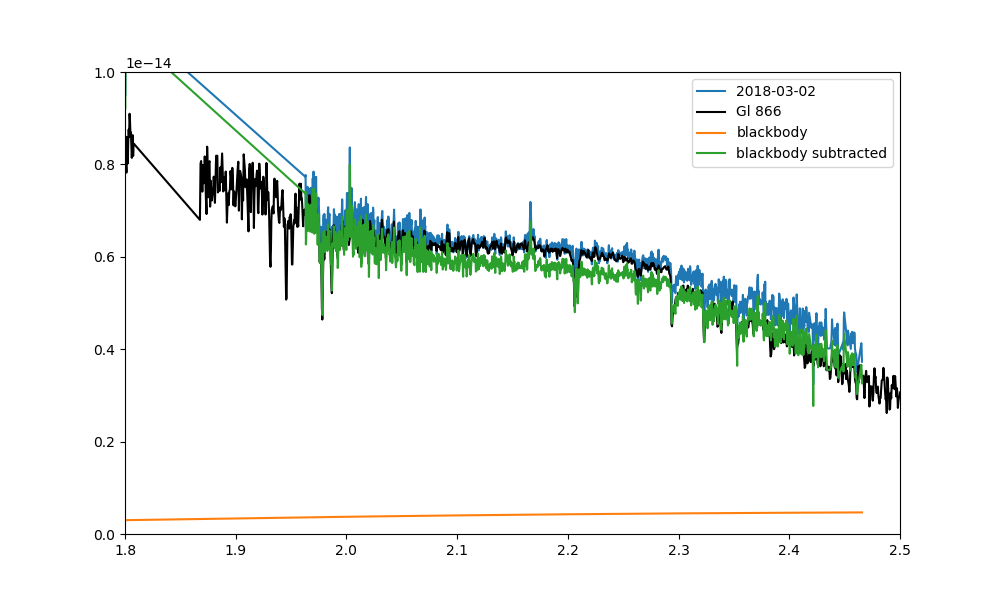

In [11]:
plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
#plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts,label='2018-03-01')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts,label='2018-03-02')
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts - awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody_trunclong_plotting)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts,label='AWI0005x3s')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged_blackbody)
#plt.ylim([1.0e-16,1.0e-13])
#plt.yscale('log',nonposy='clip')
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts - awi0005x3s_20171104_remerged_blackbody, label='AWI0005x3s blackbody subtracted')
#plt.ylim([0.,6.0e-14])
#plt.show()

<IPython.core.display.Javascript object>


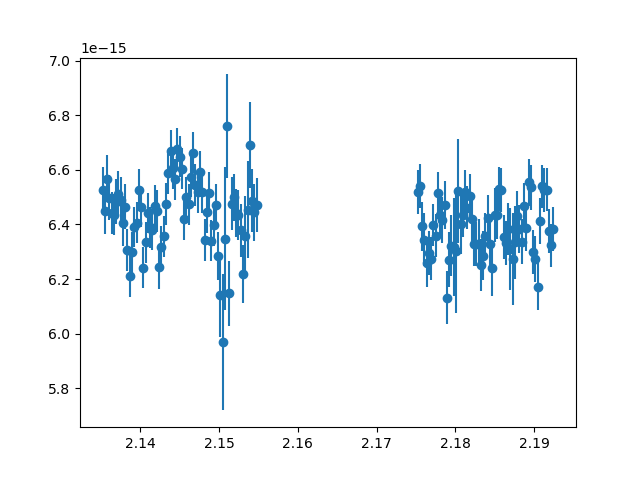

<IPython.core.display.Javascript object>


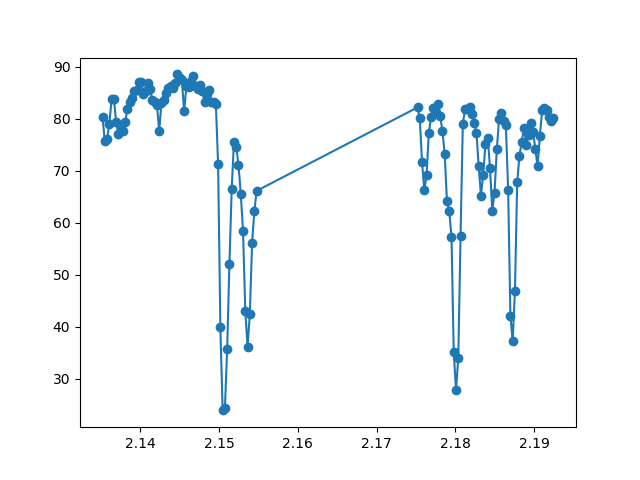

6.41709473139e-16
1.24510490132e-17
51.5385870266

6.42841528532e-16
1.2502406606e-17
51.4174229641
Right
6.38617536381e-16
9.84839779014e-18
64.8448153689
Left
6.44442924476e-16
1.37990536808e-17
46.7019651768


In [12]:
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.135 and x <2.155) or (x>2.175 and x<2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux = np.array([awi0005x3s_20171104_2mass_highsnr_flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err = np.array([awi0005x3s_20171104_2mass_highsnr_err[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])

plt.figure()
plt.errorbar(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux,yerr=awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,fmt='o')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,'o-')
plt.show()

awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux.size)/10.
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg

difs = (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.) - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg
difs_square = difs**2
avg_difs_square = np.sum(difs_square)/float(difs_square.size)
rms = avg_difs_square**0.5
print rms

snr = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_avg/rms
print snr


print ''
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.*(1./((awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err/10.)**2)))/np.sum((1./((awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err/10.)**2)))
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg

difs_errweight = (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/10.) - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg
difs_errweight_square = difs_errweight**2
avg_difs_errweight_square = np.sum(difs_errweight_square)/float(difs_errweight_square.size)
rms_errweight = avg_difs_errweight_square**0.5
print rms_errweight

snr_errweight = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_errweight_avg/rms_errweight
print snr_errweight


print 'Right'
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right = np.array([awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x.size) if (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x[i] > 2.16)])/10.
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right.size)
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg

difs_right = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg
difs_square_right = difs_right**2
avg_difs_square_right = np.sum(difs_square_right)/float(difs_square_right.size)
rms_right = avg_difs_square_right**0.5
print rms_right

snr_right = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_right_avg/rms_right
print snr_right


print 'Left'
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left = np.array([awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux[i] for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x.size) if (awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x[i] <2.16)])/10.
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg = np.sum(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left)/float(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left.size)
print awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg

difs_left = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left - awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg
difs_square_left = difs_left**2
avg_difs_square_left = np.sum(difs_square_left)/float(difs_square_left.size)
rms_left = avg_difs_square_left**0.5
print rms_left

snr_left = awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_left_avg/rms_left
print snr_left

In [16]:
def get_highsnr_continuum(continuum_spec, highsnr_wav):
    continuum_wav = continuum_spec.wavelength
    continuum_flux = continuum_spec.flux_density
    
    continuum_highsnr_wav = [x for x in continuum_wav if x in highsnr_wav]
    continuum_highsnr_flux = [continuum_flux[i] for i in range(continuum_wav.size) if (continuum_wav[i] in highsnr_wav)]
    
    return continuum_highsnr_wav, continuum_highsnr_flux

First row found: 34


<IPython.core.display.Javascript object>


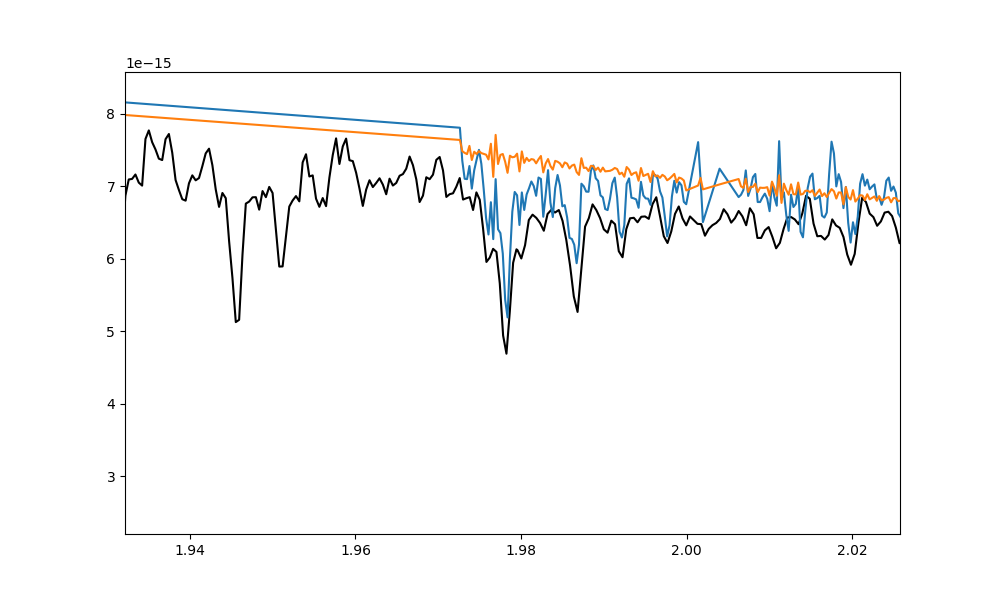

In [31]:
awi0005x3s_xtc_20171104_2massweighted_normalized = import_continuum_spectrum_from_file('awi0005x3s_xtc_20171104_2massweighted_merged_IRAF_con.txt')

#awi0005x3s_xtc_20171104_2massweighted_normalized_wav_use = np.array([x for x in awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength if x in awi0005x3s_20171104_2massweighted_merged.wav])
awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use = np.interp(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength, awi0005x3s_xtc_20171104_2massweighted_normalized.flux_density)

#print awi0005x3s_xtc_20171104_2massweighted_normalized.wavelength.size
#print awi0005x3s_20171104_2massweighted_merged.wav.size

awi0005x3s_xtc_20171104_2massweighted_continuum_flux = awi0005x3s_20171104_2mass_highsnr_flux_watts / awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use

#print awi0005x3s_xtc_20171104_2massweighted_normalized_flux_use.size
#print awi0005x3s_xtc_20171104_2massweighted_normalized_wav_use.size
#awi0005x3s_xtc_20171104_2massweighted_highsnr_wav, awi0005x3s_xtc_20171104_2massweighted_continuum_highsnr_flux = get_highsnr_continuum(awi0005x3s_xtc_20171104_2massweighted_continuum, awi0005x3s_20171104_2mass_highsnr_wav)

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav,awi0005x3s_xtc_20171104_2massweighted_continuum_flux,label='IRAF Cont.')
plt.show()